# Prova 2

Importando bibliotecas (instalar usando conda)

In [12]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from scipy.stats import multivariate_normal, bernoulli, norm

Criando variável X como normal multivariada

In [13]:
vetor_mu = np.array([1, -2, 1])
matriz_D = np.diag([0.25, 0.5, 0.75])
matriz_V = np.matrix([[1.0, 0.9, -0.1], [0.9, 1.0, -0.2], [-0.1, -0.2, 1.0]])

X = multivariate_normal(vetor_mu, matriz_D * matriz_V * matriz_D)

Criando variável Z como bernoulli onde $p = \text{FunçãoLogística(x)}$

In [14]:
Z = bernoulli

def fn_logistica_alpha(x: np.array):
    vetor_alphas = np.array([6, -0.2, 0.7, 2])
    vetor_x = np.array([1, x[0], x[1], x[0]*x[1]])
    termo_exponencial = np.exp(vetor_alphas.dot(vetor_x))
    return termo_exponencial / (1 + termo_exponencial)

Criando Y como uma normal onde $\mu = \text{Função}(x, z)$ e $\sigma^2 = 0.1^2$

In [15]:
Y = norm

def mu_Y(x, z):
    vetor_beta = np.array([10, -2, 1.2, 0.6])
    vetor_psi = np.ones(4)
    vetor_x = np.array([1, x[0], x[1], x[0]*x[1]])
    return vetor_beta.dot(vetor_x) + z * (vetor_psi.dot(vetor_x))

sigma_quadrado = 0.1 ** 2

Gerando N observações de Y e mostrando um dataframe de Y e demais variáveis

In [16]:
N = 1000
numero_variáveis = 4
amostra_y_com_covariáveis = np.empty(shape=(N, numero_variáveis + 1)) # +1 para acomodar valores de y

for n in range(N):
    x = X.rvs()
    z = Z.rvs(fn_logistica_alpha(x))
    y = Y.rvs(mu_Y(x, z), sigma_quadrado)
    amostra_y_com_covariáveis[n] = [*x, z, y]

dados = pd.DataFrame(amostra_y_com_covariáveis, columns=['X1', 'X2', 'X3', 'Z', 'Y'])
dados

,X1,X2,X3,Z,Y
0,1.044565,-2.091211,0.979787,1.0,1.871774
1,1.291421,-1.717364,2.258949,0.0,4.012451
2,1.059109,-1.969580,0.509260,1.0,2.251331
3,1.149018,-2.150409,2.179204,0.0,3.646872
4,1.010196,-2.300462,0.881740,1.0,1.220330
...,...,...,...,...,...
995,0.754524,-2.285638,0.790210,0.0,4.723531
996,0.927430,-2.191053,-0.528087,0.0,4.284774
997,1.295935,-1.397616,1.525246,1.0,3.727115
998,0.875943,-1.987129,0.137023,1.0,2.961535


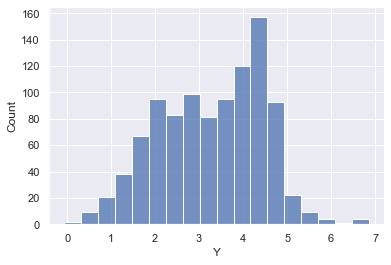

In [17]:
sns.histplot(dados.Y);

Verificando médias de cada variável

In [18]:
dados.mean()

X1    0.994729
X2   -2.007434
X3    0.967172
Z     0.671000
Y     3.281061
dtype: float64

Ajustando o modelo

In [19]:
modelo = bmb.Model('Y ~ X1*X2*X3*Z', dados)
ajuste = modelo.fit()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 989 seconds.


Verificando o ajuste

In [20]:
az.summary(ajuste)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,9.972,0.023,9.930,10.014,0.001,0.001,694.0,1361.0,1.0
X1,-1.978,0.017,-2.010,-1.949,0.001,0.000,594.0,1034.0,1.0
X2,1.189,0.008,1.174,1.203,0.000,0.000,623.0,1059.0,1.0
X1:X2,0.610,0.007,0.598,0.623,0.000,0.000,759.0,1218.0,1.0
X3,0.023,0.017,-0.009,0.055,0.001,0.000,666.0,1023.0,1.0
X1:X3,-0.016,0.012,-0.039,0.008,0.001,0.000,578.0,961.0,1.0
X2:X3,0.009,0.006,-0.002,0.019,0.000,0.000,582.0,899.0,1.0
X1:X2:X3,-0.006,0.005,-0.016,0.003,0.000,0.000,724.0,1460.0,1.0
Z,1.025,0.026,0.975,1.072,0.001,0.001,671.0,1215.0,1.0
X1:Z,0.978,0.019,0.945,1.015,0.001,0.001,568.0,1101.0,1.0


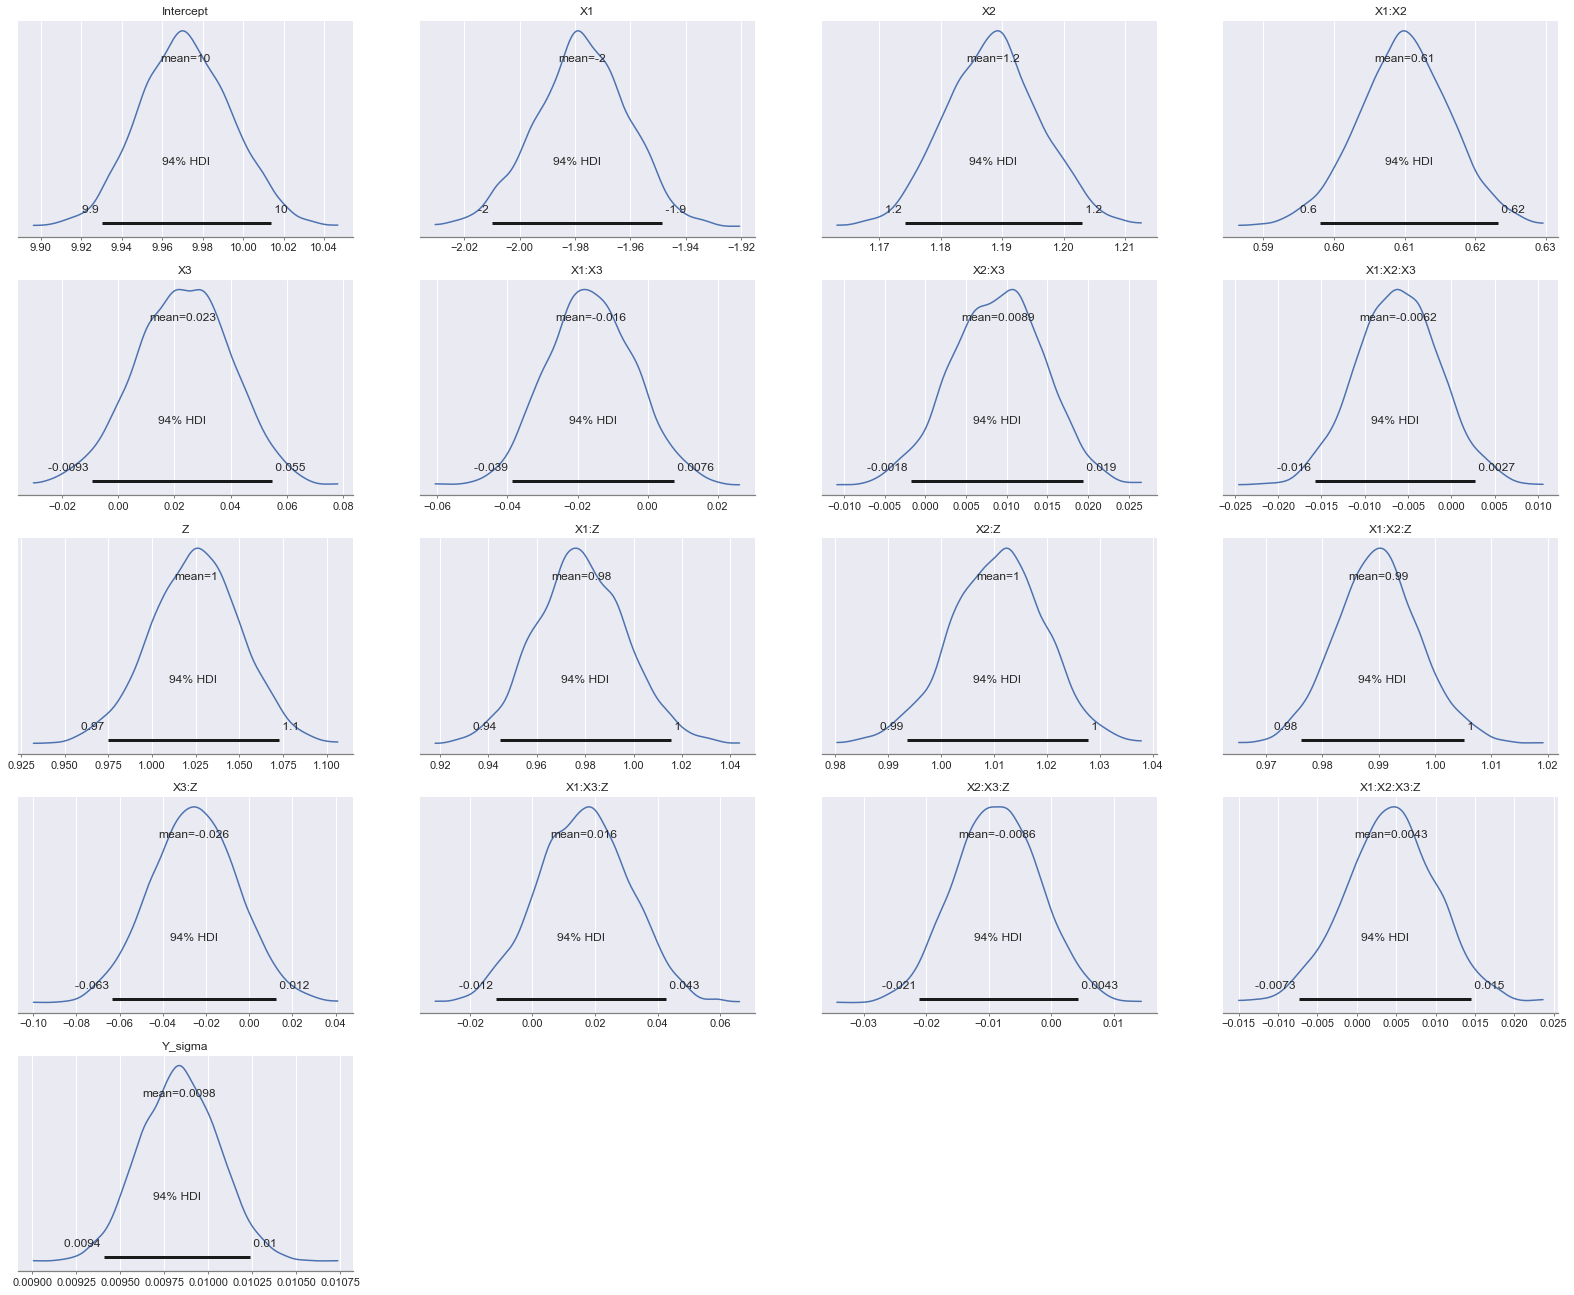

In [21]:
az.plot_posterior(ajuste);

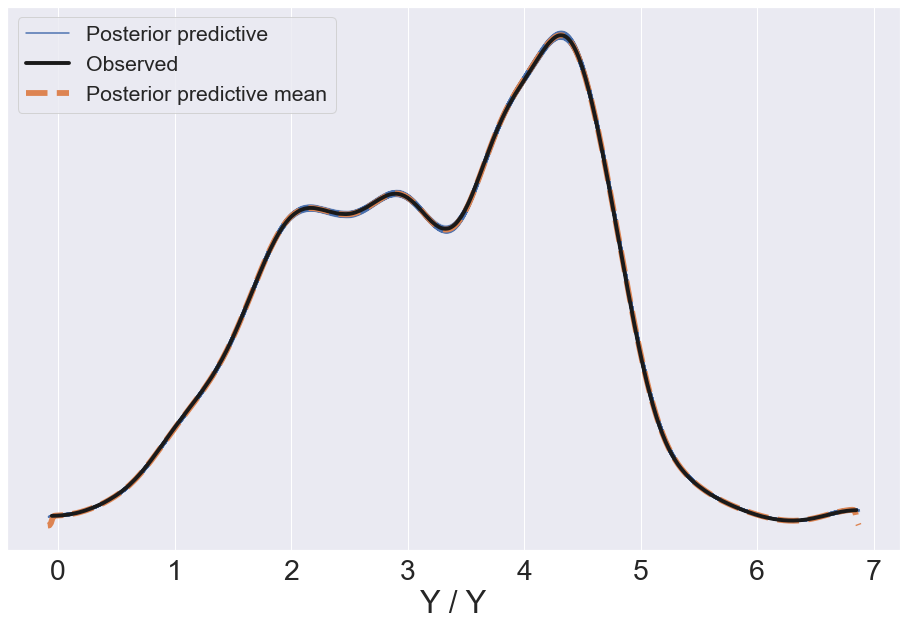

In [22]:
posterior_preditiva = modelo.predict(ajuste, kind="pps")
az.plot_ppc(ajuste, figsize=(16, 10));